In [53]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

## Crop Type Mapping: Sentinel-2 with EuroCrops

_Written by: Burak Ekim_

This tutorial will walk you through the process of performing crop type mapping with Sentinel-2 satellite imagery, annotated with EuroCrops, using TorchGeo. We will start with downloading Sentinel-2 data, setting it up with EuroCrops for pixel-wise supervised classification, training and loading a model, and perfrming qualitative and quantitative evaluation steps. 

Whether you are a remote sensing enthusiast or just curious about deep learning for geospatial data, this guide has something cool for you!

### 0- Required Imports

In [1]:
import os

import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import box
import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from urllib.parse import urlparse
import numpy as np
from skimage import exposure

import folium
from shapely.geometry import box
import geopandas as gpd
from pyproj import Transformer

from torchgeo.datasets import EuroCrops
from torchgeo.datasets import RasterDataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

%load_ext autoreload
%autoreload 2

Helper function

In [2]:
def stretch(im):
    p1, p99 = np.percentile(im, (1, 99))
    J = exposure.rescale_intensity(im, in_range=(p1, p99))
    J = J / J.max()
    return J

In [3]:
# Define the directory to save the subset windows
data_dir = r"C:\Users\burak\Desktop\tdata"
os.makedirs(data_dir, exist_ok=True)

### 1- Downloading subset Sentinel-2 Imagery

Fetch Sentinel-2 imagery using Microsoft Planetary Computer and ensure you have the data you need. Note that the Sentinel-2 imagers should match the label source both _spatially_ and _temporally_ and EuroCrops is comprised of vector-form annotations of EU countries sourced from different years. 

In [ ]:
item_url = 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20210810T095029_R079_T33UXP_20210810T215311'

# List of Sentinel-2 bands to download
bands = ['B02', 'B03', 'B04', 'B08']

# Define the AOI in EPSG:32633 UTM coordinates
minx, miny, maxx, maxy = 679422.7655,5363840.0087,694732.5082,5380241.6653
aoi = box(minx, miny, maxx, maxy)

# Retrieve the STAC item from the URL
item = pystac.Item.from_file(item_url)

# Sign the STAC item to obtain authorized asset URLs
signed_item = planetary_computer.sign(item)

# Iterate over each specified band to download the subset window
for band in bands:
    asset_href = signed_item.assets[band].href  # Get the signed URL for the band

    with rasterio.Env(aws_unsigned=False):
        with rasterio.open(asset_href) as src:
            # Verify CRS consistency
            src_crs = src.crs
            aoi_crs = "EPSG:32633"
            if src_crs.to_string() != aoi_crs:
                raise ValueError(f"CRS mismatch: AOI is in {aoi_crs}, but band {band} is in {src_crs.to_string()}")

            # Calculate the window (subset) based on AOI bounds and the image's transform
            window = from_bounds(minx, miny, maxx, maxy, transform=src.transform)

            # Read the data within the defined window for the current band
            data = src.read(1, window=window)

            # Get the transform for the window
            window_transform = src.window_transform(window)

            profile = src.profile.copy()

    # Update the profile with the new window's metadata
    profile.update({
        'height': data.shape[0],
        'width': data.shape[1],
        'transform': window_transform,
        'compress': 'lzw'
    })

    original_filename = os.path.basename(urlparse(asset_href).path)
    name, ext = os.path.splitext(original_filename)
    new_filename = f"{name}_subset{ext}"  # Add '_subset' suffix 

    output_path = os.path.join(data_dir, new_filename)

    # Check if the file already exists
    if os.path.exists(output_path):
        print(f"File already exists, skipping: {output_path}")
        continue

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)

    print(f"Saved {band} window to {output_path}")

File already exists, skipping: C:\Users\burak\Desktop\tdata\T33UXP_20210810T095029_B02_10m_subset.tif
File already exists, skipping: C:\Users\burak\Desktop\tdata\T33UXP_20210810T095029_B03_10m_subset.tif
File already exists, skipping: C:\Users\burak\Desktop\tdata\T33UXP_20210810T095029_B04_10m_subset.tif
File already exists, skipping: C:\Users\burak\Desktop\tdata\T33UXP_20210810T095029_B08_10m_subset.tif


In [6]:
item

<Item id=S2B_MSIL2A_20210810T095029_R079_T33UXP_20210810T215311>

### 2-  Prepare Dataloader

Customize TorchGeo to align `Sentinel2` and `EuroCrops` datasets, forming an `IntersectionDataset` for pixel-wise classification task

[EuroCrops](https://github.com/maja601/EuroCrops) is a dataset collection that combines all publicly available self-declared crop reporting datasets from countries in the European Union. Using the vector labels provided by EuroCrops, we define the task of supervised pixel-wise crop type mapping. Each country in the dataset has its own distinct set of crop type labels, available in varying volumes. Additionally, the temporal information (i.e., the time when the labels were created) varies across countries. Since label creation times vary, we should carefully select accompanying raster data to ensure temporal alignment, such as choosing Sentinel-2 imagery that matches the relevant year and the planting or harvesting season.

Below we are defining customizing EuroCrops to download the labels of Slovakia.

In [4]:
class EuroCropSK(EuroCrops):
    base_url = 'https://zenodo.org/records/8229128/files/'

    hcat_fname = 'HCAT2.csv'
    hcat_md5 = 'b323e8de3d8d507bd0550968925b6906'
    
    # Name of the column containing HCAT code in CSV file.
    hcat_code_column = 'HCAT2_code'

    label_name = 'EC_hcat_c'

    filename_glob = '*_EC*.shp'
    
    # Regex for timestamp extraction.
    filename_regex = r"""
        ^(?P<country>[A-Z]{2})
        (_(?P<region>[A-Z]+))?
        _
        (?P<date>\d{4})
        _
        (?P<suffix>EC(?:21)?)
        \.shp$
    """
    date_format = '%Y'
    zenodo_files: tuple[tuple[str, str], ...] = (
        ('SK_2021.zip', 'c7762b4073869673edc08502e7b22f01'),
    )

Customizing `RasterDataset` to handle the downloaded Sentinel-2 patches:

In [5]:
class Sentinel2Custom(RasterDataset):
    filename_glob = 'T*_B0*_10m_subset.tif'
    filename_regex = r'^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0\d)'
    date_format = '%Y%m%dT%H%M%S'
    is_image = True
    separate_files = True
    all_bands = ('B02', 'B03', 'B04', 'B08')
    rgb_bands = ('B04', 'B03', 'B02')
    
    def plot(self, sample):
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        image = sample['image'][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 10000, min=0, max=1).numpy()

        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [6]:
#TODO this is a dirty workaround -- is there an alternative to that? I must be doing something wrong
import torchgeo.datasets
torchgeo.datasets.Sentinel2 = Sentinel2Custom
torchgeo.datasets.EuroCrops = EuroCropSK

Defining a `GeoDataModule` that combines the two datasets including file verification, CRS reprojection, and sampling to match pixel sizes. 

In [39]:
from torchgeo.datamodules import Sentinel2EuroCropsDataModule

hcat_classes =  ['3301010600',
                '3301010200',
                '3301060401',
                '3301010101',
                '3301290700',
                '3301010402',
                '3301060500',
                '3301010102',
                '3301090301']

datamodule = Sentinel2EuroCropsDataModule(
    sentinel2_paths=data_dir,
    eurocrops_paths=data_dir,
    batch_size=4,
    patch_size=128,
    length=100,
    num_workers=0,
    eurocrops_download=True,
    persistent_workers=True,
    eurocrops_classes=hcat_classes,
)

datamodule.setup("fit")
train_dataset = datamodule.train_dataset
datamodule.setup("validate")
val_dataset = datamodule.val_dataset
datamodule.setup("test")
test_dataset = datamodule.test_dataset

Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0
Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0
Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0


The samples are drawn from with the abstractions `RandomBatchGeoSampler` (for training) or `GridGeoSampler` (validation and test) 

In [40]:
next(iter(datamodule.train_batch_sampler))

[BoundingBox(minx=691485.2655, maxx=692765.2655, miny=5366431.6653, maxy=5367711.6653, mint=1628581829.0, maxt=1628581829.999999),
 BoundingBox(minx=691255.2655, maxx=692535.2655, miny=5366211.6653, maxy=5367491.6653, mint=1628581829.0, maxt=1628581829.999999),
 BoundingBox(minx=691345.2655, maxx=692625.2655, miny=5366221.6653, maxy=5367501.6653, mint=1628581829.0, maxt=1628581829.999999),
 BoundingBox(minx=691125.2655, maxx=692405.2655, miny=5366431.6653, maxy=5367711.6653, mint=1628581829.0, maxt=1628581829.999999)]

In [41]:
len(datamodule.train_dataset), len(datamodule.val_dataset), len(datamodule.test_dataset)

(205, 26, 25)

Checking if the two sources match in CRS, bound, and res

In [42]:
datamodule.sentinel2.files, datamodule.sentinel2.crs, datamodule.sentinel2.bounds, datamodule.sentinel2.crs, datamodule.eurocrops.files, datamodule.eurocrops.bounds, datamodule.sentinel2.res, datamodule.eurocrops.res

(['C:\\Users\\burak\\Desktop\\tdata\\T33UXP_20210810T095029_B02_10m_subset.tif',
  'C:\\Users\\burak\\Desktop\\tdata\\T33UXP_20210810T095029_B03_10m_subset.tif',
  'C:\\Users\\burak\\Desktop\\tdata\\T33UXP_20210810T095029_B04_10m_subset.tif',
  'C:\\Users\\burak\\Desktop\\tdata\\T33UXP_20210810T095029_B08_10m_subset.tif'],
 CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'),
 BoundingBox(minx=679422.7655, maxx=694732.7655, miny=53638

In [43]:
width = datamodule.sentinel2.bounds.maxx - datamodule.sentinel2.bounds.minx
height = datamodule.sentinel2.bounds.maxy - datamodule.sentinel2.bounds.miny
print(f"BoundingBox Width: {width} meters")
print(f"BoundingBox Height: {height} meters")

BoundingBox Width: 15310.0 meters
BoundingBox Height: 16400.0 meters


In [44]:
datamodule.sentinel2.bounds.intersects(datamodule.eurocrops.bounds)

True

In [45]:
s2_crop = datamodule.sentinel2[datamodule.sentinel2.bounds]
eurocrops_crop = datamodule.eurocrops[datamodule.sentinel2.bounds]

In [46]:
eurocrops_crop

{'mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [6, 6, 6,  ..., 0, 0, 0],
         [6, 6, 6,  ..., 0, 0, 0],
         [6, 6, 6,  ..., 0, 0, 0]]),
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'),
 'bounds': BoundingBox(minx=679422.7655, maxx=694732.7655, miny=5363841.6653, maxy=5380241.6653, mint=1628581829.0, maxt=1628581829.999999)}

Looking at the `class_map`, we see how the crop types are encoded to form a mask. Below, we visualize the types and their occurrence frequencies in our AOI. [See here](https://www.eurocrops.tum.de/taxonomy.html) for more on HCAT codes.

In [47]:
np.unique(eurocrops_crop['mask'], return_counts=True), datamodule.eurocrops.class_map

((array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  array([808407, 423612, 261300, 253561, 226281, 153951, 137800, 125749,
          74417,  45762])),
 {'3301010600': 1,
  '3301010200': 2,
  '3301060401': 3,
  '3301010101': 4,
  '3301290700': 5,
  '3301010402': 6,
  '3301060500': 7,
  '3301010102': 8,
  '3301090301': 9})

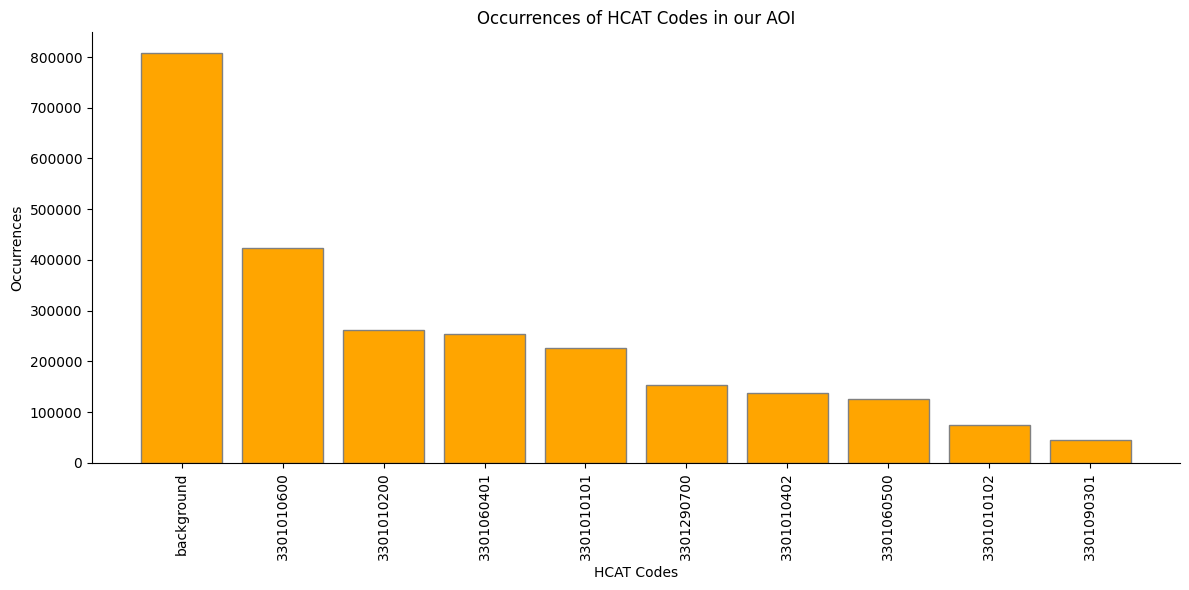

In [48]:
# Occurrences of unique crop types in the mask
unique, occ = np.unique(eurocrops_crop['mask'], return_counts=True)

# Reverse lookup mapping
reverse_class_map = {v: k for k, v in datamodule.eurocrops.class_map.items()}

# Prepare HCAT codes and frequencies
hcat_codes = ['background' if u == 0 else reverse_class_map[u] for u in unique if u in reverse_class_map or u == 0]
code_freq = [y for u, y in zip(unique, occ) if u in reverse_class_map or u == 0]

# Plotting the updated bar chart
plt.figure(figsize=(12, 6))
plt.bar(hcat_codes, code_freq, color='orange', edgecolor='grey')
plt.xlabel('HCAT Codes')
plt.ylabel('Occurrences')
plt.title('Occurrences of HCAT Codes in our AOI')
plt.xticks(rotation=90)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

Get the top-10 classes by their occurances 
- TODO: Delete the cell below. It was essentially used to find the top10 HCAT classes by their occurances in our AOI. Once found, I set those classes as argument to `EuroCropSK`

In [49]:
unique, occ = np.unique(eurocrops_crop['mask'], return_counts=True)

# Reverse lookup mapping for class_map
reverse_class_map = {v: k for k, v in datamodule.eurocrops.class_map.items()}

# Filter and map to HCAT codes
hcat_codes = ['background' if u == 0 else reverse_class_map[u] for u in unique if u in reverse_class_map or u == 0]
code_freq = [y for u, y in zip(unique, occ) if u in reverse_class_map or u == 0]
code_freq = [int(y) for y in code_freq]

# Pair HCAT codes with their frequencies and sort by frequency in descending order
sorted_codes = sorted(zip(hcat_codes, code_freq), key=lambda x: x[1], reverse=True)

# Get the top 10 HCAT codes and their frequencies
top_10_hcat_codes = sorted_codes[:10]
top_10_hcat_codes_list = [code for code, _ in top_10_hcat_codes]
top_10_hcat_codes_list

['background',
 '3301010600',
 '3301010200',
 '3301060401',
 '3301010101',
 '3301290700',
 '3301010402',
 '3301060500',
 '3301010102',
 '3301090301']

Let's map the Sentinel-2 and crop annotations are

In [50]:
def visualize_bounding_boxes(sentinel_bounds, eurocrops_bounds, sentinel_crs, eurocrops_crs):
    # Unpack the bounds
    minx1, maxx1, miny1, maxy1 = sentinel_bounds.minx, sentinel_bounds.maxx, sentinel_bounds.miny, sentinel_bounds.maxy
    minx2, maxx2, miny2, maxy2 = eurocrops_bounds.minx, eurocrops_bounds.maxx, eurocrops_bounds.miny, eurocrops_bounds.maxy

    # Transform to WGS84 EPSG:4326
    sentinel_transformer = Transformer.from_crs(sentinel_crs, "EPSG:4326", always_xy=True)
    eurocrops_transformer = Transformer.from_crs(eurocrops_crs, "EPSG:4326", always_xy=True)

    minx1, miny1 = sentinel_transformer.transform(minx1, miny1)
    maxx1, maxy1 = sentinel_transformer.transform(maxx1, maxy1)

    minx2, miny2 = eurocrops_transformer.transform(minx2, miny2)
    maxx2, maxy2 = eurocrops_transformer.transform(maxx2, maxy2)

    bbox1 = box(minx1, miny1, maxx1, maxy1)
    bbox2 = box(minx2, miny2, maxx2, maxy2)

    gdf1 = gpd.GeoDataFrame({"geometry": [bbox1]}, crs="EPSG:4326")
    gdf2 = gpd.GeoDataFrame({"geometry": [bbox2]}, crs="EPSG:4326")

    center_lat = (miny1 + maxy1) / 2
    center_lon = (minx1 + maxx1) / 2
    m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

    folium.GeoJson(gdf1, style_function=lambda x: {"color": "blue", "weight": 2}, name="Sentinel-2 Patch Bounds").add_to(m)
    folium.GeoJson(gdf2, style_function=lambda x: {"color": "green", "weight": 2}, name="EuroCrop Slovakie Bounds").add_to(m)

    folium.LayerControl().add_to(m)

    return m

map = visualize_bounding_boxes( datamodule.sentinel2.bounds,  datamodule.eurocrops.bounds,  datamodule.sentinel2.crs,  datamodule.eurocrops.crs)
map

#### Visualize the Sentinel-2 imagery and EuroCrops Labels

Since the label bounds is encompasses the Sentinel-2 patch bounds, we query the labels to the extent of Sentinel-2 patch

In [51]:
# Temporal bounds (the last to dims of BoundingBox) are not crucial for this usecase
datamodule.sentinel2.bounds

BoundingBox(minx=679422.7655, maxx=694732.7655, miny=5363841.6653, maxy=5380241.6653, mint=1628581829.0, maxt=1628581829.999999)

- Split the tile by 80-20 then use one for train and the other for inference 

In [52]:
s2_crop['image'].shape, eurocrops_crop['mask'].shape, eurocrops_crop['mask'].unique()

(torch.Size([4, 1640, 1531]),
 torch.Size([1640, 1531]),
 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

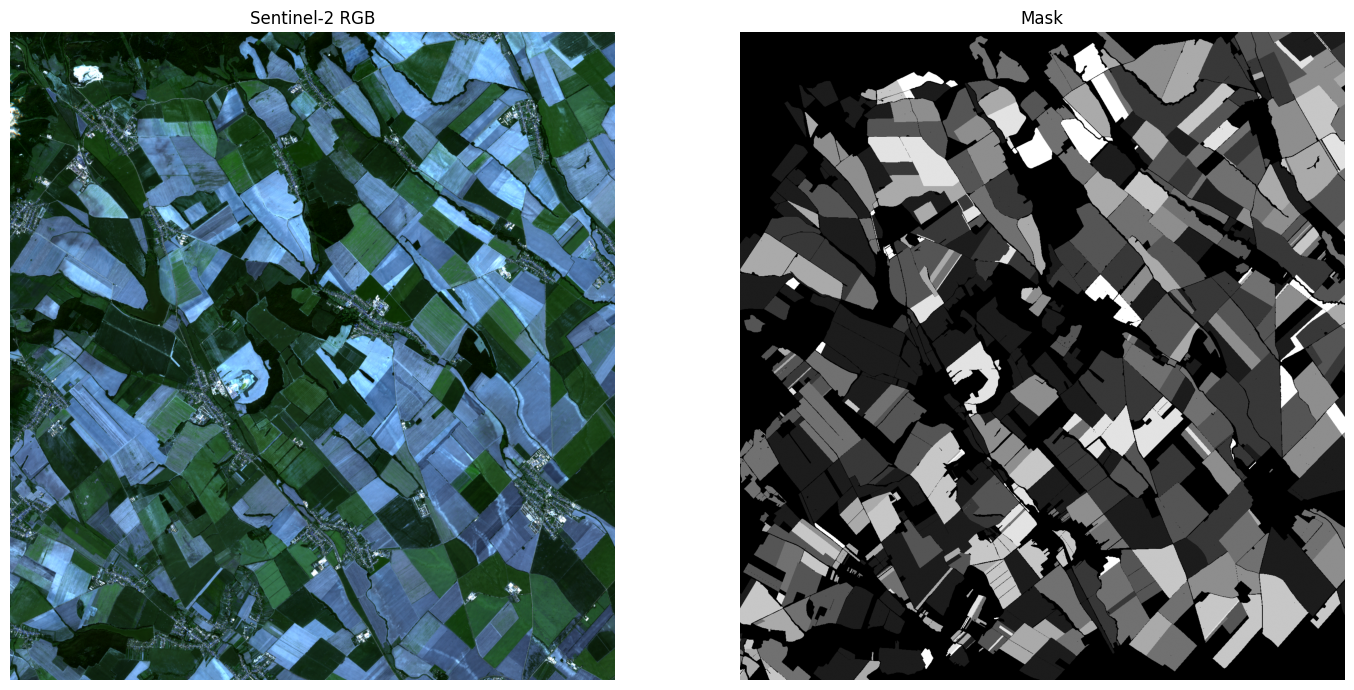

In [53]:
image_tensor = s2_crop['image']
mask_tensor = eurocrops_crop['mask']
image_mask_tuple = (image_tensor, mask_tensor)

# Extract image and mask
image, mask = image_mask_tuple
rgb_image = image[:3, :, :]
rgb_image_np = rgb_image.numpy().transpose(1, 2, 0) / 10000
rgb_image_np_str = stretch(rgb_image_np)
mask_np = mask.numpy()

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot the Sentinel-2 image
axes[0].imshow(rgb_image_np_str)
axes[0].set_title('Sentinel-2 RGB')
axes[0].axis('off')

# Plot the Mask
axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off') 

plt.tight_layout()
plt.show()

### 3- Training Semantic Segmentation Model

Train a UNet model with Sentinel-2 images paired with EuroCrops labels to classify crop type, powered by PyTorch Lightning

In [54]:
from torchgeo.trainers import SemanticSegmentationTask
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=os.path.join(data_dir, 'checkpoints'),
    filename='s2_eurocrops-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min', 
    save_weights_only=True,
    verbose=True
    )

task = SemanticSegmentationTask(
    model='unet',
    backbone='resnet50',
    weights=True, # Imagenet weights
    in_channels=4,
    num_classes=10,
    num_filters=3,
    loss='ce',
    class_weights=None,
    ignore_index=None,
    lr=0.001,
    patience=10,
    freeze_backbone=True,
    freeze_decoder=False)

trainer = Trainer(
    accelerator='cpu',
    default_root_dir=data_dir,
    fast_dev_run=False,
    log_every_n_steps=10,
    max_epochs=3,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback]
    )

trainer.fit(model=task, datamodule=datamodule)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\burak\anaconda3\envs\torchgeo_env\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\burak\Desktop\tdata\checkpoints exists and is not empty.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Unet             | 32.5 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
---------------------------------------

Files already downloaded and verified
Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0
Epoch 0: 100%|██████████| 25/25 [08:11<00:00,  0.05it/s, v_num=2]

INFO: Epoch 0, global step 25: 'val_loss' reached 3.60290 (best 3.60290), saving model to 'C:\\Users\\burak\\Desktop\\tdata\\checkpoints\\s2_eurocrops-epoch=00-val_loss=3.60.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 25: 'val_loss' reached 3.60290 (best 3.60290), saving model to 'C:\\Users\\burak\\Desktop\\tdata\\checkpoints\\s2_eurocrops-epoch=00-val_loss=3.60.ckpt' as top 3


Epoch 1: 100%|██████████| 25/25 [07:49<00:00,  0.05it/s, v_num=2]

INFO: Epoch 1, global step 50: 'val_loss' reached 2.16289 (best 2.16289), saving model to 'C:\\Users\\burak\\Desktop\\tdata\\checkpoints\\s2_eurocrops-epoch=01-val_loss=2.16.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 50: 'val_loss' reached 2.16289 (best 2.16289), saving model to 'C:\\Users\\burak\\Desktop\\tdata\\checkpoints\\s2_eurocrops-epoch=01-val_loss=2.16.ckpt' as top 3


Epoch 2: 100%|██████████| 25/25 [07:54<00:00,  0.05it/s, v_num=2]

INFO: Epoch 2, global step 75: 'val_loss' reached 1.68577 (best 1.68577), saving model to 'C:\\Users\\burak\\Desktop\\tdata\\checkpoints\\s2_eurocrops-epoch=02-val_loss=1.69.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 75: 'val_loss' reached 1.68577 (best 1.68577), saving model to 'C:\\Users\\burak\\Desktop\\tdata\\checkpoints\\s2_eurocrops-epoch=02-val_loss=1.69.ckpt' as top 3
INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 25/25 [07:55<00:00,  0.05it/s, v_num=2]


### 4- Model Evaluation on Test Set

Evaluate the segmentation model over the test set

In [38]:
# Load the best checkpoint
best_ckpt = checkpoint_callback.best_model_path
if not best_ckpt:
   best_ckpt = os.path.join(data_dir, 'checkpoints', 's2_eurocrops-epoch=00-val_loss=54.15.ckpt')

task = SemanticSegmentationTask.load_from_checkpoint(best_ckpt)

datamodule.setup(stage='test')
test_results = trainer.test(model=task, datamodule=datamodule)

print("Test Results:", test_results)

c:\Users\burak\anaconda3\envs\torchgeo_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0
Files already downloaded and verified
Files already downloaded and verified
Converting EuroCropSK CRS from EPSG:4326 to EPSG:32633
Converting EuroCropSK res from 1e-05 to 10.0
Testing: |          | 25/? [04:21<00:00,  0.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_MulticlassAccuracy   │     0.25876709818840027     │
│ test_MulticlassJaccardIndex │     0.1486114114522934      │
│          test_loss          │      51.97197341918945      │
└─────────────────────────────┴─────────────────────────────┘

Test Results: [{'test_loss': 51.97197341918945, 'test_MulticlassAccuracy': 0.25876709818840027, 'test_MulticlassJaccardIndex': 0.1486114114522934}]


### Inference over the complete Sentinel-2

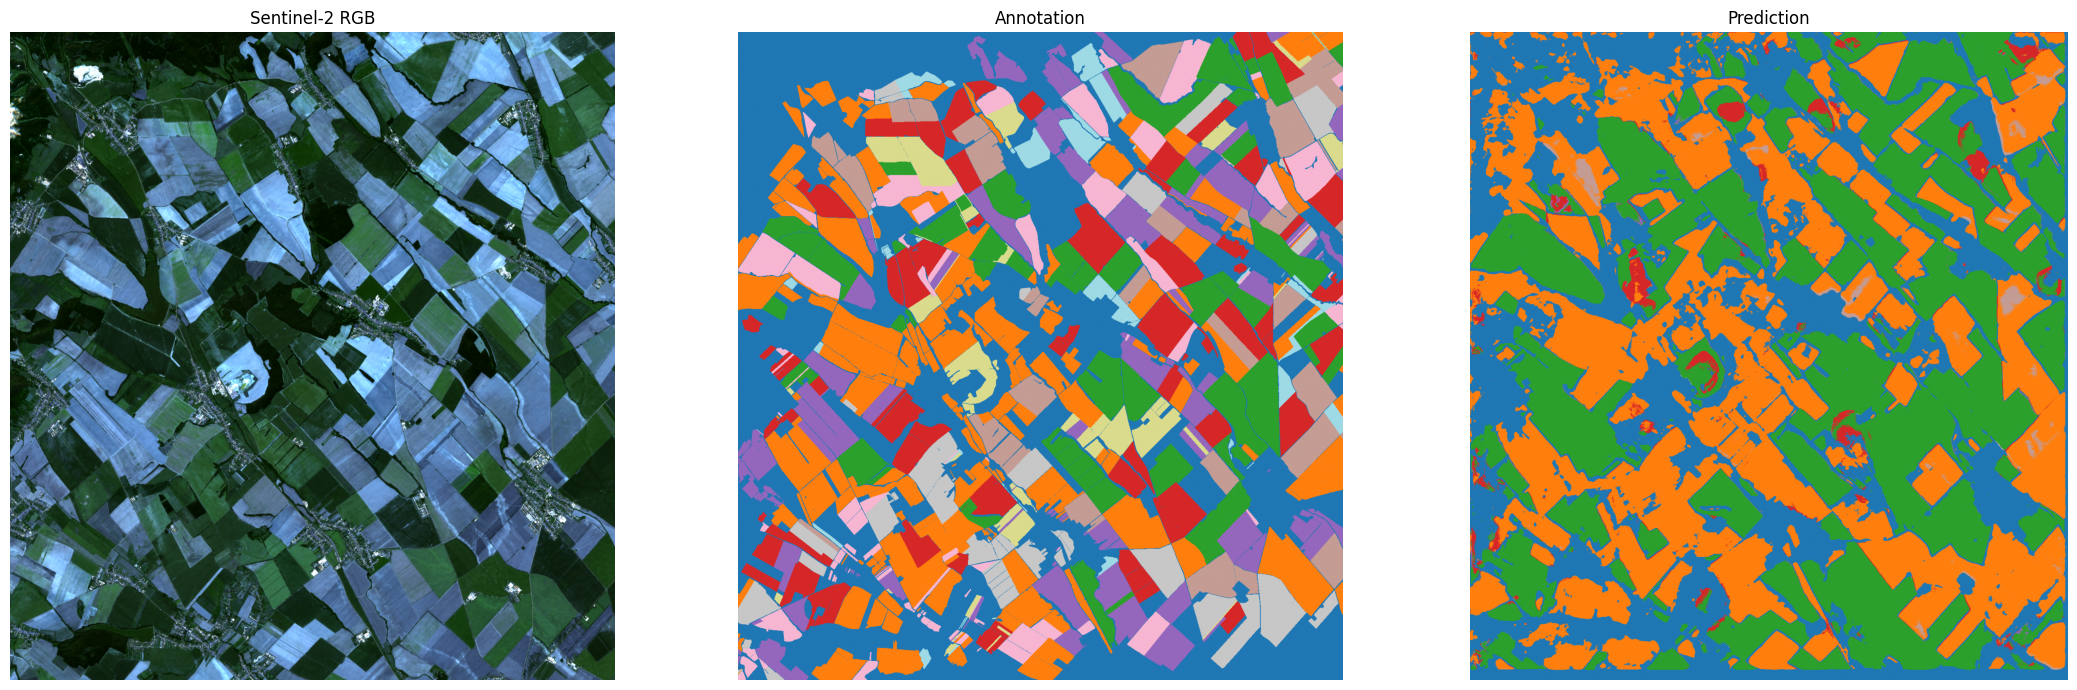

In [ ]:
import torch.nn.functional as F

image_tensor = s2_crop['image']
mask_tensor = eurocrops_crop['mask']

input_tensor = image_tensor.unsqueeze(0)

# Pad to make input tensor divisible by 32
*_, h, w = input_tensor.shape
new_h = ((h + 31) // 32) * 32
new_w = ((w + 31) // 32) * 32
pad_h = new_h - h
pad_w = new_w - w
input_tensor_padded = F.pad(input_tensor, (0, pad_w, 0, pad_h), mode='constant', value=0) / 10000

with torch.no_grad():
    output = task(input_tensor_padded)
    pred_mask = torch.argmax(output, dim=1).squeeze(0).numpy()

rgb_image = image_tensor[:3, :, :]
rgb_image_np = rgb_image.numpy().transpose(1, 2, 0) / 10000
rgb_image_np_str = stretch(rgb_image_np)

mask_np = mask_tensor.numpy()
num_classes = 10

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

axes[0].imshow(rgb_image_np_str)
axes[0].set_title('Sentinel-2 RGB')
axes[0].axis('off')

axes[1].imshow(mask_np, cmap='tab20', vmin=0, vmax=num_classes-1)
axes[1].set_title('Annotation')
axes[1].axis('off')

axes[2].imshow(pred_mask, cmap='tab20', vmin=0, vmax=num_classes-1)
axes[2].set_title('Prediction')
axes[2].axis('off')

plt.tight_layout()
plt.show()